## Семинар 1 "Полносвязные нейронные сети"

ФИО: Валиахметов Булат Ильдарович

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros(output_size)        
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X @ self.W + self.b
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        
        #y = WX + b
        #dLdW = dLdy * dydw
        #dydw = x
        
        self.dLdW = (dLdy.T @ self.X).T
        self.dLdb = dLdy.sum(axis=0)
        
        dLdx = dLdy @ self.W.T
        
        return dLdx

    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        
        self.W -= learning_rate * self.dLdW
        self.b -= learning_rate * self.dLdb

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [3]:
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    eps = 10**(-5)
    
    f_grad = np.zeros(gradient.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps            
            f_r = func(X)
            X[i, j] -= 2*eps            
            f_l = func(X)            
            X[i, j] += eps
                    
            f_grad[i, j] = (f_r - f_l) / 2 / eps
    
    return np.max(np.abs(gradient - f_grad))

In [4]:
np.random.seed(777)
x = np.random.rand(10, 20)
func = lambda x: (x**2).sum()
gradient = 2*x
check_gradient(func, x, gradient)

5.662181834509283e-10

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [5]:
# dL / dW check
np.random.seed(777)

X = np.array([[0, 1], [1, 1]])
Y = np.array([[0], [1]])

l = Linear(2, 1)

def loss(W):
    l.W = W
    
    res = l.forward(X)
    
    return np.sum((res - Y)**2)

res = l.forward(X)
print(res)
dLdy = 2*(res - Y)
print(dLdy)

l.backward(dLdy)

print(l.dLdW)

check_gradient(loss, l.W, l.dLdW)

[[-0.00822825]
 [-0.01291034]]
[[-0.0164565 ]
 [-2.02582067]]
[[-2.02582067]
 [-2.04227717]]


9.583001059354501e-12

In [6]:
# dL / dX check
np.random.seed(777)

X = np.array([[-1, 1], [1, -1]], dtype=float)
Y = np.array([[-1], [1]], dtype=float)

l = Linear(2, 1)
def mse(X):
    tmp = l.forward(X)
    return np.sum((tmp - Y) ** 2)

res = l.forward(X)
dLdy = 2 * (res - Y)

dLdx = l.backward(dLdy)
print(dLdx)

check_gradient(mse, X, dLdx)

[[-0.00933097 -0.01639814]
 [ 0.00933097  0.01639814]]


1.2861964965305006e-11

### Часть 3: Сигмоида

In [7]:
def sigma(X):
    return 1 / (1 + np.exp(-X))


class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return sigma(X)
        
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * sigma(self.X) * (1 - sigma(self.X))
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [8]:
# dL / dX check
np.random.seed(777)

X = np.array([[-1, 1], [1, -1]], dtype=float)
Y = np.array([[-1], [1]], dtype=float)

s = Sigmoid()
def mse(X):
    tmp = s.forward(X)
    return np.sum((tmp - Y) ** 2)

res = s.forward(X)
dLdy = 2 * (res - Y)

dLdx = s.backward(dLdy)
print(dLdx)

check_gradient(mse, X, dLdx)

[[ 0.49897805  0.68069355]
 [-0.10575419 -0.28746968]]


2.549538358209702e-11

### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

$ \dfrac{dL}{dx} = \dfrac{dL}{dp_k}\dfrac{dp_k}{dx} = -\dfrac{1}{p_k} p_k \big((1-p_k)dx_k - \sum\limits_{i \neq k} p_i dx_i\big) = (p_k - 1)dx_k + \sum\limits_{i \neq k} p_i dx_i, \text{где } k = y_{true} $

In [9]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y
        
        NLL_loss = 0
        for i in range(X.shape[0]):
            c_max = np.max(X[i])
            NLL_loss += -X[i, y[i]] + c_max + np.log(np.sum(np.exp(X[i] - c_max)))
        return NLL_loss
        
        
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = np.zeros(shape=self.X.shape)
        for i in range(self.X.shape[0]):
            c_max = np.max(self.X[i])
            log_sum = self.X[i] - (c_max + np.log(np.sum(np.exp(self.X[i] - c_max))))
            probs = np.exp(log_sum)
            dLdx[i] = probs
            dLdx[i, self.y[i]] = probs[self.y[i]] - 1
        return dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [10]:
# dL / dX check
np.random.seed(777)

X = np.random.randn(6, 3)
y = np.random.randint(low=0, high=3, size=6)

nll = NLLLoss()

def loss(X):
    return nll.forward(X, y)

res = nll.forward(X, y)
dLdx = nll.backward()

check_gradient(loss, X, dLdx)

6.671091457022271e-11

### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [11]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules
    
    def forward(self, X):
        cur = X
        for layer in self.modules:
            cur = layer.forward(cur)
        return cur
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for layer in self.modules[::-1]:
            dLdy = layer.backward(dLdy)
    
    def step(self, learning_rate):
        for layer in self.modules:
            layer.step(learning_rate)

### Часть 6, обучение на простых данных

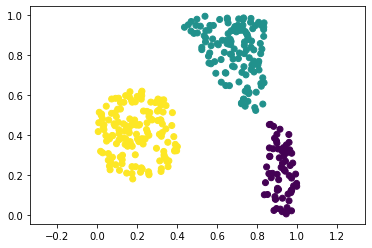

In [12]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

In [13]:
learning_rate = 0.005
max_epoch = 2000
modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]

nn = NeuralNetwork(modules)
loss_func = NLLLoss()
losses = []

for _ in range(max_epoch):
    ans = nn.forward(X)
    losses.append(loss_func.forward(ans, y))
    dLdy = loss_func.backward()
    nn.backward(dLdy)
    nn.step(learning_rate)
    print('\r current loss: {}'.format(losses[-1]), end='')

 current loss: 0.8158732434092839

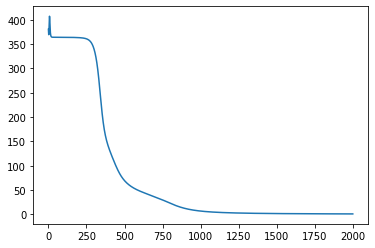

In [14]:
plt.plot(losses)

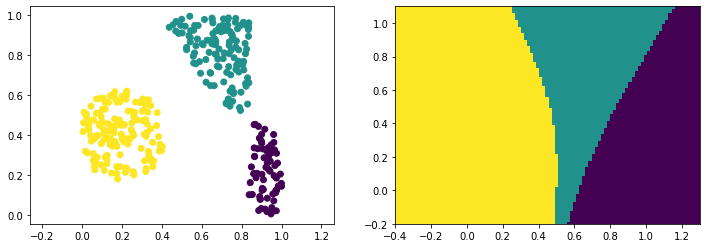

In [15]:
dx, dy = (100, 100)
x_lin = np.linspace(-0.4, 1.3, dx)
y_lin = np.linspace(-0.2, 1.1, dy)
Xc, Yc = np.meshgrid(x_lin, y_lin)
C = np.zeros((dx-1, dy-1))
for i in range(dx-1):
    for j in range(dy-1):
        results = []
        for k in range(i, i+2):
            for m in range(j, j+2):
                res = nn.forward(np.array([[Xc[k, m], Yc[k, m]]]))
                res = np.argmax(res)
                results.append(res)
        counts = np.bincount(np.array(results))
        C[i, j] = np.argmax(counts)

plt.rcParams["figure.figsize"] = (12, 4)
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')

plt.subplot(122)
plt.pcolormesh(Xc, Yc, C)
plt.show()

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

Подбор темпа обучения

In [16]:
l_rates = [0.001, 0.0025, 0.005, 0.0075,  0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
max_epoch = 1000

all_losses = []
opt_losses = []

for learning_rate in l_rates:
    modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
    nn = NeuralNetwork(modules)
    loss_func = NLLLoss()
    losses = []
    for _ in range(max_epoch):
        ans = nn.forward(X)
        losses.append(loss_func.forward(ans, y))
        dLdy = loss_func.backward()
        nn.backward(dLdy)
        nn.step(learning_rate)
        print('\r rate = {}, current loss: {}'.format(learning_rate, losses[-1]), end='')
    opt_losses.append(min(losses))
    all_losses.append(losses)

 rate = 0.25, current loss: 10319.10994638257472

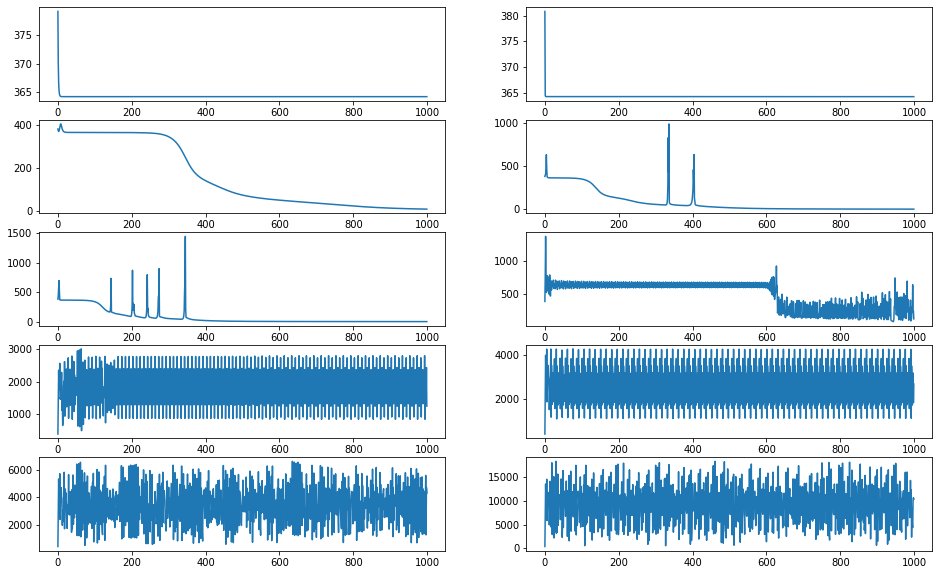

In [17]:
plt.rcParams["figure.figsize"] = (16, 10)
fig, ax = plt.subplots(5, 2)
for i in range(5):
    for j in range(2):
        ax[i, j].plot(all_losses[2 * i + j])
plt.show()

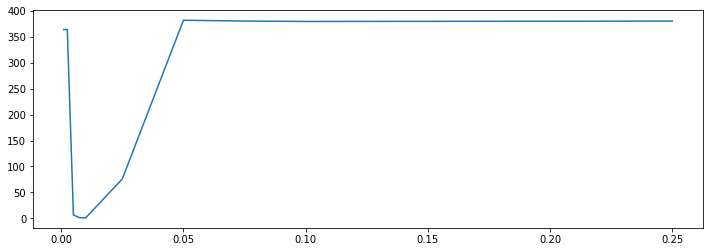

In [18]:
plt.rcParams["figure.figsize"] = (12, 4)
plt.plot(l_rates, opt_losses)

In [19]:
print(np.array([l_rates, opt_losses]).T)

[[1.00000000e-03 3.64209364e+02]
 [2.50000000e-03 3.64198054e+02]
 [5.00000000e-03 6.52151712e+00]
 [7.50000000e-03 1.35392726e+00]
 [1.00000000e-02 8.30046965e-01]
 [2.50000000e-02 7.60044959e+01]
 [5.00000000e-02 3.82058118e+02]
 [7.50000000e-02 3.80500049e+02]
 [1.00000000e-01 3.79729173e+02]
 [2.50000000e-01 3.80400715e+02]]


При достаточно малых значениях learning_rate (<0.005) сходимости за 1000 эпох всё ещё не наблюдается, а при достаточно больших значениях (>0.025) сходимости нет, так как шаг вдоль антиградиента слишком высок. При средних значениях шага заметны скачки loss'а, однако при достаточно большом количестве эпох их уже нет, сходимость стабилизируется. Приемлемо выбирать шаги от 0.005 до 0.01.

Оптимальное значение learnig_rate = 0.01.

Итого для этого значения график ниже:

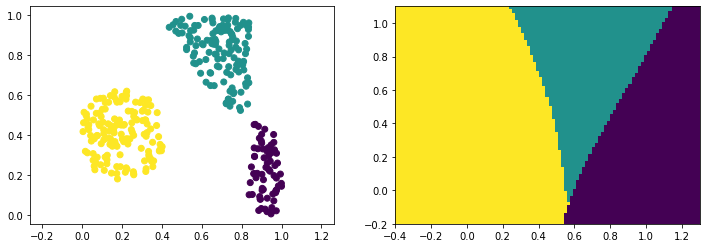

In [20]:
modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
nn = NeuralNetwork(modules)
loss_func = NLLLoss()
learning_rate = 0.01
max_epoch = 2000

for _ in range(max_epoch):
    ans = nn.forward(X)
    loss_func.forward(ans, y)
    dLdy = loss_func.backward()
    nn.backward(dLdy)
    nn.step(learning_rate)

dx, dy = (100, 100)
x_lin = np.linspace(-0.4, 1.3, dx)
y_lin = np.linspace(-0.2, 1.1, dy)
Xc, Yc = np.meshgrid(x_lin, y_lin)
C = np.zeros((dx-1, dy-1))
for i in range(dx-1):
    for j in range(dy-1):
        results = []
        for k in range(i, i+2):
            for m in range(j, j+2):
                res = nn.forward(np.array([[Xc[k, m], Yc[k, m]]]))
                res = np.argmax(res)
                results.append(res)
        counts = np.bincount(np.array(results))
        C[i, j] = np.argmax(counts)

plt.rcParams["figure.figsize"] = (12, 4)
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')

plt.subplot(122)
plt.pcolormesh(Xc, Yc, C)
plt.show()

In [21]:
weights = sum([np.linalg.norm(nn.modules[i].W) for i in [0, 2, 4]])
print("NLL weights", weights)

NLL weights 45.491855079911645


Решим теперь задачу регрессии с MSE.

In [22]:
class MSELoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y.reshape(-1, 1)
        # print(self.X.T, self.y.T, sep='\n', end='\n\n')
        return np.mean((X - self.y) ** 2)
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = 2 * (self.X - self.y) / self.X.shape[0]
        return dLdx

In [23]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']

In [24]:
l_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8]
max_epoch = 5000

all_losses = []
opt_losses = []

for learning_rate in l_rates:
    modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)]
    nn = NeuralNetwork(modules)
    loss_func = MSELoss()
    losses = []
    for _ in range(max_epoch):
        ans = nn.forward(X)
        losses.append(loss_func.forward(ans, y))
        dLdy = loss_func.backward()
        nn.backward(dLdy)
        nn.step(learning_rate)
        print('\r rate = {}, current loss: {}'.format(learning_rate, losses[-1]), end='', flush=True)
    opt_losses.append(min(losses))
    all_losses.append(losses)

 rate = 0.8, current loss: 0.065264170079259396

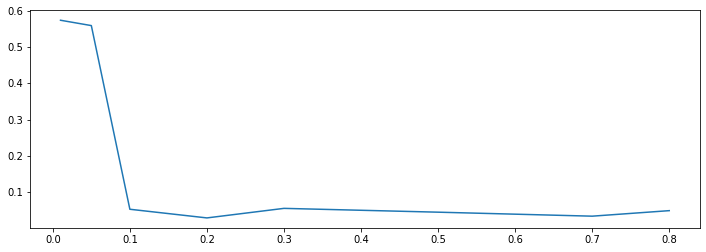

In [25]:
plt.rcParams["figure.figsize"] = (12, 4)
plt.plot(l_rates, opt_losses)

Видим, что для MSE нужно брать learning_rate выше - от 0.2 вполне приемлемо. Выберем 0.5 и обучим финальную модель.

In [26]:
learning_rate = 0.5
max_epoch = 10000
modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)]

nn = NeuralNetwork(modules)
loss_func = MSELoss()
losses = []

for _ in range(max_epoch):
    ans = nn.forward(X)
    losses.append(loss_func.forward(ans, y))
    dLdy = loss_func.backward()
    nn.backward(dLdy)
    nn.step(learning_rate)
    print('\r current loss: {}'.format(losses[-1]), end='', flush=True)

 current loss: 0.022328971001716637

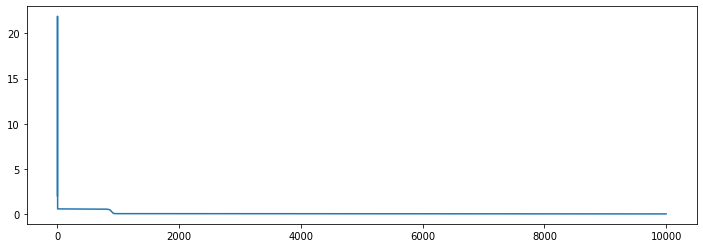

In [27]:
plt.plot(losses)

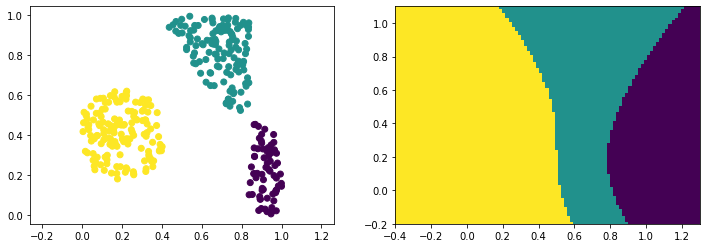

In [28]:
dx, dy = (100, 100)
x_lin = np.linspace(-0.4, 1.3, dx)
y_lin = np.linspace(-0.2, 1.1, dy)
Xc, Yc = np.meshgrid(x_lin, y_lin)
C = np.zeros((dx-1, dy-1))
for i in range(dx-1):
    for j in range(dy-1):
        results = []
        for k in range(i, i+2):
            for m in range(j, j+2):
                res = nn.forward(np.array([[Xc[k, m], Yc[k, m]]]))
                res = int(res + 0.5)
                #print(res)
                results.append(res)
        counts = np.bincount(np.array(results))
        C[i, j] = np.argmax(counts)

plt.rcParams["figure.figsize"] = (12, 4)
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')

plt.subplot(122)
plt.pcolormesh(Xc, Yc, C)
plt.show()

Из графика функции потерь видно, что итерационный процесс сошелся. Разделяющиеся поверхности изменились.

In [29]:
weights = sum([np.linalg.norm(nn.modules[i].W) for i in [0, 2, 4]])
print("MSE weights", weights)

MSE weights 22.288480456794247
